# Team Lovelace : #TODO (ecrire le titre) <img src="../Data/Images/LinkedIn_logo_initials.png" width="25">

Welcome to our project notebook for Milestone P2! In this phase, our team has worked on refining our project proposal and conducting preliminary analyses to set the stage for a successful data exploration and analysis journey. 

Our project aims to analyze the careers of actors present in our dataset. In this milestone, we delve into initial analyses and data handling tasks, ensuring that our proposed project is feasible given the available datasets.

## Imports


In [78]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from helpers import *

import warnings

# Ignoring warnings to improve code readability
warnings.filterwarnings("ignore")

# Resetting Matplotlib default settings
plt.rcdefaults()

# Set the maximum number of rows to display
pd.set_option('display.max_rows', 20)

## Loading Datasets

In [79]:
# Setting the paths to the data folders
DATA_FOLDER = "../Data/"
CMU_PATH = DATA_FOLDER + "MovieSummaries/"
IMDB_PATH = DATA_FOLDER + "IMDb/"
OSCARS_PATH = DATA_FOLDER + "Oscars/"

# Reading CMU Movie & Character metadata
cmu_movies_raw = pd.read_csv(CMU_PATH + "movie.metadata.tsv", sep="\t",)
cmu_characters_raw = pd.read_csv(CMU_PATH + "character.metadata.tsv", sep="\t")


# Reading IMDb basics and ratings data
imdb_movies_raw = pd.read_csv(
    IMDB_PATH + "title.basics.tsv.gz", sep="\t", compression="gzip"
)
imdb_ratings_raw = pd.read_csv(
    IMDB_PATH + "title.ratings.tsv.gz", sep="\t", compression="gzip"
)

# Reading Oscars data
oscars_raw = pd.read_csv(
    OSCARS_PATH + "the_oscar_award.csv",
)


# TODO Import other dataset (Don't forget to add comments as above)

### Renaming Columns

Both CMU datasets, `cmu_movies_raw` and `cmu_characters_raw`, initially lacked column names (#TODO ajouter les noms des autres datasets entre `...` si nécessaires). To address this, we have provided names in the cell below. For the CMU dataset, you can refer to the descriptions of each column [here](http://www.cs.cmu.edu/~ark/personas/). (#TODO pareil mettre les liens pour les autres datasets)


In [80]:
cmu_movies_raw.columns = [
    "wikiID",
    "fbID",
    "movieName",
    "releaseDate",
    "boxOffice",
    "runtime",
    "languages",
    "countries",
    "genres",
]

cmu_characters_raw.columns = [
    "wikiID",
    "fbID",
    "releaseDate",
    "characterName",
    "actorDOB",
    "actorGender",
    "actorHeight",
    "actorEthnicity",
    "actorName",
    "ageAtMovieRelease",
    "fbCharacterMap",
    "fbCharacterID",
    "fbActorID",
]

cmu_movies_raw.drop(columns="wikiID", inplace=True) #TODO expliquer pk on drop au dessus
cmu_characters_raw.drop(columns="wikiID", inplace=True)
#TODO add les noms ici si necessaire pour les autres datasets

To ensure consistency in column names across datasets, we have renamed some columns in the other datasets (to match the conventions of the CMU dataset) in the cell below.

In [81]:
imdb_movies_raw.rename(
    columns={
        "tconst": "imdbID", 
        "primaryTitle": "movieName",
        "startYear": "releaseYear",
        "runtimeMinutes": "runtime",
    },
    inplace=True
)

imdb_ratings_raw.rename(
    columns={
        "tconst": "imdbID", 
    },
    inplace=True
)

oscars_raw.rename(
    columns={
        "year_film": "releaseYear",
        "year_ceremony": "yearCeremony",
        "name": "actorName",
        "film": "movieName",
    },
    inplace=True
)

# TODO rename les columns des autres datasets si nécessaire

## Merging Datasets

Before merging the datasets, it is important to clean and standardize the column formats for the columns we intend to merge on. To facilitate this process, we create copies of our raw dataframes. This ensures that we don't need to reload them if we want to start the cleaning process from scratch.

In [82]:
cmu_movies = cmu_movies_raw.copy()
cmu_characters = cmu_characters_raw.copy()

imdb_movies = imdb_movies_raw.copy()
imdb_ratings = imdb_ratings_raw.copy()

oscars = oscars_raw.copy()

### Cleaning columns `movieName` & `actorName`

#TODO Michael explain why et comment tu le fais pour les deux datasets cmu movies et imdb et autres

In [83]:
# cleaning titles #TODO #dans oscars, et both cmu 

### Cleaning column `releaseDate`

The `cmu_movies` and `cmu_characters` dataset exhibit variable date formats, with some entries providing day, month, and year, while others only contain the year. To enhance clarity and facilitate analysis, we've decided to split the `releaseDate` column into separate columns for `releaseMonth` and `releaseYear`. In contrast, the `imdb_movies` and `oscars` datasets provides release dates in the year-only format.

In [84]:
# Cmu movies & characters

# Months
cmu_movies["releaseMonth"] = pd.to_datetime(
    cmu_movies["releaseDate"], errors="coerce", dayfirst=True
).dt.month
cmu_characters["releaseMonth"] = pd.to_datetime(
    cmu_characters["releaseDate"], errors="coerce", yearfirst=True
).dt.month

# Year
cmu_movies["releaseYear"] = pd.to_datetime(
    cmu_movies["releaseDate"], errors="coerce", format="mixed", dayfirst=True
).dt.year
cmu_characters["releaseYear"] = pd.to_datetime(
    cmu_characters["releaseDate"], errors="coerce", format="mixed", dayfirst=True
).dt.year

# Drop releaseDate column
cmu_movies.drop(columns=["releaseDate"], inplace=True)
cmu_characters.drop(columns=["releaseDate"], inplace=True)


# Imdb & Oscars
imdb_movies["releaseYear"] = pd.to_datetime(
    imdb_movies["releaseYear"], errors="coerce", format="%Y"
).dt.year

oscars["releaseYear"] = pd.to_datetime(
    oscars["releaseYear"], errors="coerce", format="%Y"
).dt.year

### Cleaning column `runtime`

The `runtime` column for the `imdb_movies` dataset contains '\N' values instead of 'NaN'.

In [85]:
imdb_movies["runtime"] = pd.to_numeric(imdb_movies["runtime"], errors="coerce")

#TODO other columns to clean pour merger??

### Merging

In the following cell, we perform two left merges:

1. **CMU Movies and IMDb Merged Data:**
   - We merge the `cmu_movies` dataset with the merged IMDb dataset based on the common columns `["movieName", "releaseYear", "runtime"]`. The resulting DataFrame, named `movies_merged`, contains combined information from both datasets, with column suffixes "Cmu" for columns from the CMU dataset and "Imdb" for columns from the IMDb dataset.
<br>
<br>
2. **CMU Characters and Oscars:**
   - We merge the `cmu_characters` dataset with the `oscars` dataset based on the common columns `["actorName", "releaseYear", "movieName"]` using a left join.
   

#TODO other merge to do. Adapter les textes au dessus et il faut max deux datasets. un qui s'appelle actors et l'autre movies




In [86]:
# Merging CMU Movies with IMDb Merged Data
movies_merged = pd.merge(
    cmu_movies,
    imdb_movies.merge(imdb_ratings, how="left", on="imdbID"), # IMDb movies & ratings
    how="left",
    on=["movieName", "releaseYear", "runtime"],
    suffixes=["Cmu", "Imdb"],
)

# Merging CMU Characters with Oscars
characters_merged = pd.merge(
    cmu_characters.merge(
        cmu_movies[["fbID", "movieName"]], how="left", on="fbID"
    ), # add movieName in cmu_characters
    oscars,
    how="left",
    on=["actorName", "releaseYear", "movieName"],
)

As before, we copy our DataFrame to avoid running the merge cell in case we make modifications incorrectly and wish to restart from this point.

In [87]:
movies = movies_merged.copy()
characters = characters_merged.copy()

Given that our analysis primarily centers on actors rather than movies characters, we construct a new dataframe `actors` from `characters` emphasizing actor-related information. The columns are rearranged to provide a perspective centered on actors. Following this, we filter out rows without a Freebase actor ID, as they only contain character information without actor-related details.

In [212]:
actors = characters[
    [
        "fbActorID",
        "actorName",
        "actorGender",
        "actorDOB",
        "actorHeight",
        "actorEthnicity",
        "fbID",
        "ageAtMovieRelease",
        "category",
        "winner",
    ]
]

actors = actors.sort_values(by=actors.columns.to_list(), ignore_index=True)
actors = actors.dropna(subset="fbActorID")

In [215]:
actors = actors.groupby(
    [
        "fbActorID",
        "actorName",
        "actorGender",
        "actorDOB",
        "actorHeight",
        "actorEthnicity",
    ],
    dropna=False
).apply(actors_agg).reset_index() #ATTENTION TRES LONG #TODO remove cette remarque 

In [216]:
explode_on_movies(actors)

,fbActorID,actorName,actorGender,actorDOB,actorHeight,actorEthnicity,fbID,ageAtMovieRelease,category,winner
0,/m/010p3,Adam Carolla,M,1964-05-27,1.880,/m/0xnvg,/m/03qk61v,44.0,NaN,NaN
0,/m/010p3,Adam Carolla,M,1964-05-27,1.880,/m/0xnvg,/m/047dv64,NaN,NaN,NaN
0,/m/010p3,Adam Carolla,M,1964-05-27,1.880,/m/0xnvg,/m/051wrdv,35.0,NaN,NaN
0,/m/010p3,Adam Carolla,M,1964-05-27,1.880,/m/0xnvg,/m/06c5z_,33.0,NaN,NaN
0,/m/010p3,Adam Carolla,M,1964-05-27,1.880,/m/0xnvg,/m/06zm9p7,33.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
135758,/m/0zcbl,Paul Giamatti,M,1967-06-06,1.740,/m/033tf_,/m/0k3lpxc,46.0,None,None
135758,/m/0zcbl,Paul Giamatti,M,1967-06-06,1.740,/m/033tf_,/m/0kvf09,42.0,None,None
135758,/m/0zcbl,Paul Giamatti,M,1967-06-06,1.740,/m/033tf_,/m/0kvf6s,40.0,None,None
135758,/m/0zcbl,Paul Giamatti,M,1967-06-06,1.740,/m/033tf_,/m/0q9b0,32.0,None,None


In [90]:
print("MOVIES")
display(movies)
print("ACTORS")
display(actors)

MOVIES


,fbID,movieName,boxOffice,runtime,languages,countries,genresCmu,releaseMonth,releaseYear,imdbID,titleType,originalTitle,isAdult,endYear,genresImdb,averageRating,numVotes
0,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biograp...",2.0,2000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,/m/0crgdbh,Brun bitter,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""D...",NaN,1988.0,tt0094806,movie,Brun bitter,0,\N,"Crime,Drama",5.6,40.0
2,/m/0285_cd,White Of The Eye,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic...",NaN,1987.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,/m/01mrr1,A Woman in Flames,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",NaN,1983.0,tt0083949,movie,Die flambierte Frau,0,\N,Drama,6.0,621.0
4,/m/03cfc81,The Gangsters,NaN,35.0,"{""/m/06ppq"": ""Silent film"", ""/m/02h40lc"": ""Eng...","{""/m/09c7w0"": ""United States of America""}","{""/m/02hmvc"": ""Short Film"", ""/m/06ppq"": ""Silen...",5.0,1913.0,tt0002894,short,The Gangsters,0,\N,"Comedy,Short",6.8,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83121,/m/0j7hxnt,Mermaids: The Body Found,NaN,120.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/07s9rl0"": ""Drama""}",3.0,2011.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83122,/m/0g4pl34,Knuckle,NaN,96.0,"{""/m/02h40lc"": ""English Language""}","{""/m/03rt9"": ""Ireland"", ""/m/07ssc"": ""United Ki...","{""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0...",1.0,2011.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83123,/m/02pygw1,Another Nice Mess,NaN,66.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/06nbt"": ""Satire"", ""/m/01z4y"": ""Comedy""}",9.0,1972.0,tt0362411,movie,Another Nice Mess,0,\N,Comedy,5.8,110.0
83124,/m/03pcrp,The Super Dimension Fortress Macross II: Lover...,NaN,150.0,"{""/m/03_9r"": ""Japanese Language""}","{""/m/03_3d"": ""Japan""}","{""/m/06n90"": ""Science Fiction"", ""/m/0gw5n2f"": ...",5.0,1992.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


ACTORS


,fbActorID,actorName,actorGender,actorDOB,actorHeight,actorEthnicity,fbID,ageAtMovieRelease,category,winner
0,/m/010p3,Adam Carolla,M,1964-05-27,1.880,/m/0xnvg,"[/m/03qk61v, /m/047dv64, /m/051wrdv, /m/06c5z_...","{'/m/03qk61v': 44.0, '/m/051wrdv': 35.0, '/m/0...",NaN,NaN
1,/m/010q36,Fred Rogers,M,1928-03-20,NaN,NaN,[/m/033pf1],{'/m/033pf1': 67.0},NaN,NaN
2,/m/010wx,Aria Giovanni,F,1977-11-03,1.680,/m/03q819,[/m/07gx0c],{'/m/07gx0c': 25.0},NaN,NaN
3,/m/010xjr,Richard Harris,M,1930-10-01,1.850,/m/03bkbh,"[/m/015gl2, /m/0273r02, /m/02qf1bq, /m/02qf7sl...","{'/m/0273r02': 68.0, '/m/02qf1bq': 36.0, '/m/0...",{'/m/015gl2': 'ACTOR'},{'/m/015gl2': False}
4,/m/0112yl,Toshiro Mifune,M,1920-04-01,1.740,NaN,"[/m/018lr7, /m/019npw, /m/01j5x_, /m/01nv95, /...","{'/m/018lr7': 41.0, '/m/019npw': 30.0, '/m/01n...",NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
135755,/m/0z58,Ardal O'Hanlon,M,1965-10-08,NaN,NaN,[/m/027cvd8],NaN,NaN,NaN
135756,/m/0z9q0,"José Luis Rodríguez ""El Puma""",M,1943-01-14,NaN,NaN,[/m/0gls5qd],{'/m/0gls5qd': 69.0},NaN,NaN
135757,/m/0zcb7,Marcus Giamatti,M,1961-10-03,1.850,NaN,"[/m/02drs7, /m/03b1xl, /m/047fs6w, /m/080kkcx,...","{'/m/02drs7': 40.0, '/m/03b1xl': 29.0, '/m/047...",NaN,NaN
135758,/m/0zcbl,Paul Giamatti,M,1967-06-06,1.740,/m/033tf_,"[/m/01510v, /m/01hv3t, /m/01pgnr, /m/024tb7, /...","{'/m/01510v': 31.0, '/m/01hv3t': 30.0, '/m/01p...",{'/m/050gkf': 'ACTOR IN A SUPPORTING ROLE'},{'/m/050gkf': False}


## NOM DE LA QUESTION SUR LES GENRES #TODO

## Cleaning the genres

The `genresCmu` column, while having very few missing values, exhibits a wide diversity of genres, as outlined in the cell below. Additionally, the genres are not standardized; for instance, we observe distinctions like 'Action', 'Adventure' and 'Action/Adventure' making it challenging to analyze. As for `genresImdb`, we have a reasonably manageable number of unique genres. However, due to the merge, we notice a considerable number of missing values compared to `genresCmu`.

In [91]:
# Updating the 'genresCmu' and 'genresImdb' columns to get a list of genres without the IDs for each movie
movies['genresCmu'] = movies['genresCmu'].apply(parse_dict)
movies['genresImdb'] = movies['genresImdb'].apply(
    lambda x: x.split(',') if not (isinstance(x, float) or x=="\\N") else np.nan)

In [92]:
percent_missing = movies.isnull().sum() * 100 / len(movies)
print(
    f"Proportion of missing values in each column:\n{ percent_missing[['genresCmu', 'genresImdb']]}"
)

number_genres_cmu = len(movies.genresCmu.explode().unique())
number_genres_imdb = len(movies.genresImdb.explode().unique())
print("\nNumber of unique genres in\n"+ 
      "CMU:",number_genres_cmu,"\n"
      "Imdb:", number_genres_imdb)

Proportion of missing values in each column:
genresCmu      2.932897
genresImdb    62.216394
dtype: float64

Number of unique genres in
CMU: 364 
Imdb: 29


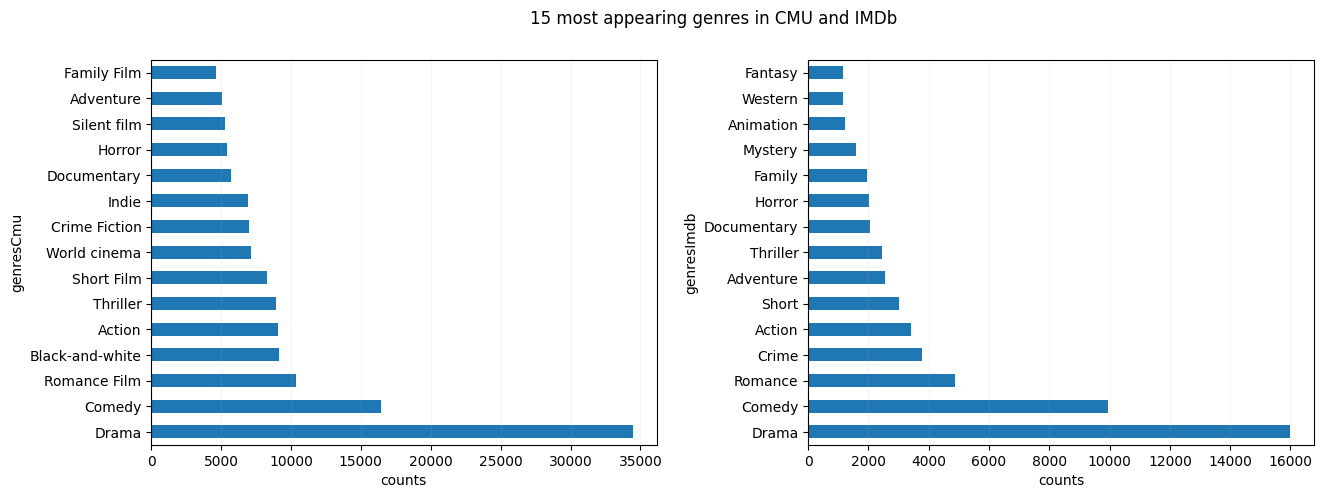

In [93]:
fig = plt.figure(figsize=(15,5))
fig.suptitle( "15 most appearing genres in CMU and IMDb")

fig.add_subplot(121)
occurences_cmu = movies["genresCmu"].explode().value_counts()
occurences_cmu[:15].plot(kind='barh')
plt.grid(alpha=0.15, axis="x")
plt.xlabel("counts")

fig.add_subplot(122)
occurences_imdb = movies["genresImdb"].explode().value_counts()
occurences_imdb[:15].plot(kind='barh')
plt.grid(alpha=0.15, axis="x")
plt.xlabel("counts")

plt.subplots_adjust(wspace=0.3)

To address the issue of numerous missing values in 'Imdb' and the diversity of genres in 'CMU', we will first combine the genres for each movie.

In [94]:
combinedGenres = movies["genresImdb"].apply(
    lambda x: list(x) if isinstance(x, list) else []
) + movies["genresCmu"].apply(lambda x: list(x) if isinstance(x, list) else [])

combinedGenres = combinedGenres.apply(lambda x: set(x) if len(x) > 0 else np.nan)

movies["combinedGenres"] = combinedGenres
movies["combinedGenres"]

0         {Drama, Crime Drama, Biographical film, Mystery}
1                            {Drama, Crime Fiction, Crime}
2        {Thriller, Erotic thriller, Psychological thri...
3                                                  {Drama}
4        {Silent film, Short, Comedy, Short Film, Black...
                               ...                        
83121                                              {Drama}
83122              {Drama, Biographical film, Documentary}
83123                                     {Comedy, Satire}
83124    {Drama, Science Fiction, Japanese Movies, Shor...
83125                    {Thriller, Teen, Horror, Slasher}
Name: combinedGenres, Length: 83126, dtype: object

Once we have a set of unique genres for each movie, the idea is to create a long string by concatenating all the genres for all the movies.

In [95]:
genres = movies.dropna(subset="combinedGenres").explode(column="combinedGenres").combinedGenres.values
genres_str = " ".join(str(g) for g in genres)

genres_unique = np.unique(genres)

Then we want to split this long string using the `split_characters` found by the code. This will, for example, allow us to split the genre 'Action/Adventure' into 'Adventure' and 'Action'. The list `words` contains all the words appearing throughout all the combinedGenres. The more a word appears in the list `words`, the more it appears in combinedGenres.

In [96]:
split_characters = set()
for letter in genres_str:
    if (
        not letter.isalpha() and letter != " "
    ):  # letter.isalpha() return True if the letter is an alphabetic string
        split_characters.add(letter)

print(split_characters)

string = genres_str
for delimiter in split_characters:
    string = " ".join(string.split(delimiter))

words = string.split(" ")
print("\nThe first 15 terms of the list words", words[:15])

{'9', '&', ']', '[', "'", '5', '-', '/'}

The first 15 terms of the list words ['Drama', 'Crime', 'Drama', 'Biographical', 'film', 'Mystery', 'Drama', 'Crime', 'Fiction', 'Crime', 'Thriller', 'Erotic', 'thriller', 'Psychological', 'thriller']


Now, our objective is to identify the most frequently occurring words in our list of `words`. As one can observe above, some words are presented in uppercase, while others are in lowercase. To ensure consistency, we convert all text to lowercase and proceed to identify words that appear more than 2000 times. 

In [97]:
words = list(map(lambda x: x.lower(), words))

counts = pd.Series(words).value_counts()
new_genres_serie = pd.Series(counts[counts > 2000])
new_genres_serie.index

Index(['drama', 'film', 'comedy', 'action', 'romance', 'crime', 'thriller',
       'adventure', 'fiction', 'short', 'black', 'and', 'white', 'family',
       'cinema', 'world', 'indie', 'horror', 'romantic', 'documentary',
       'silent', 'musical', 'movies', 'fantasy', 'animation', 'mystery', 'war',
       '', 'science', 'movie', 'western', 'japanese', 'biography'],
      dtype='object')

Finally, we have a list of words representing our new genres. After filtering out words that do not correspond to actual genres, we create a dictionary, `genres_dict`, linking genres from 'CMU' and 'IMDb' to our new list of genres. For example, all genres containing the word 'drama' will be associated with the genre 'Drama.' 

A list of genres associated with 'Drama' is displayed two cells below.

In [98]:
# Dropping irrelevant genres and characters from the series
new_genres_serie = new_genres_serie.drop(
    index=[
        "",
        "film",
        "cinema",
        "movie",
        "movies",
        "black",
        "and",
        "white",  # combining "black-and-white" instead of having separate entries
    ]
)

# Adding "black-and-white" to the indices
new_genres_serie["black-and-white"] = 0

# Capitalizing the new genres and create a list from the indices
new_genres = list(map(lambda x: x.capitalize(), new_genres_serie.index))

genres_dict = {genre: set() for genre in new_genres}
for new_genre in new_genres:
    for genre in genres_unique:
        if new_genre.lower() in genre.lower():
            genres_dict[new_genre].add(genre)

# Merging "Romantic" into "Romance" since can be considered equivalent
genres_dict["Romance"] = genres_dict["Romance"].union(genres_dict.pop("Romantic"))
new_genres.remove("Romantic")

print(len(new_genres), "unified genres listed below")
new_genres

25 unified genres listed below


['Drama',
 'Comedy',
 'Action',
 'Romance',
 'Crime',
 'Thriller',
 'Adventure',
 'Fiction',
 'Short',
 'Family',
 'World',
 'Indie',
 'Horror',
 'Documentary',
 'Silent',
 'Musical',
 'Fantasy',
 'Animation',
 'Mystery',
 'War',
 'Science',
 'Western',
 'Japanese',
 'Biography',
 'Black-and-white']

In [99]:
genres_dict["Drama"]

{'Addiction Drama',
 'Childhood Drama',
 'Comedy-drama',
 'Costume drama',
 'Courtroom Drama',
 'Crime Drama',
 'Docudrama',
 'Drama',
 'Erotic Drama',
 'Family Drama',
 'Fantasy Drama',
 'Historical drama',
 'Inspirational Drama',
 'Legal drama',
 'Marriage Drama',
 'Melodrama',
 'Musical Drama',
 'Political drama',
 'Romantic drama'}

In conclusion to the cleaning process, we apply the function `unify_genres()` to our column combinedGenres, creating the new unique column genres. This transformation ensures that the genres are now meaningful for our analysis.

Proportion of missing values in column genres 4.03%


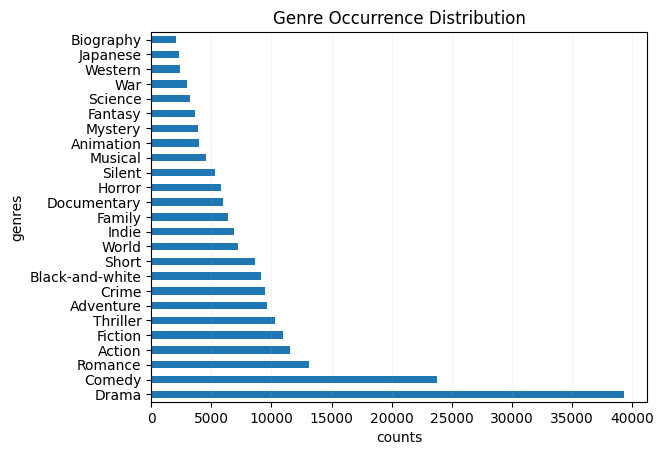

In [100]:
def unify_genres(x):
    try:
        unified_genres = set()
        for genre in x:
            themes_in_genres = {t for t in new_genres if genre in genres_dict[t]}
            unified_genres = unified_genres.union(themes_in_genres)
        return unified_genres if unified_genres else np.nan

    except TypeError:
        return x


movies["genres"] = movies["combinedGenres"].apply(unify_genres)
# movies.drop(columns=["genresCmu","genresImdb","combinedGenres"],inplace=True) #TODO uncomment

occurences = movies["genres"].explode().value_counts()
occurences.plot(kind="barh")
plt.title("Genre Occurrence Distribution")
plt.grid(alpha=0.15, axis="x")
plt.xlabel("counts")

percent_missing = movies["genres"].isnull().sum() / len(movies)
print(f"Proportion of missing values in column genres {percent_missing:.2%}")

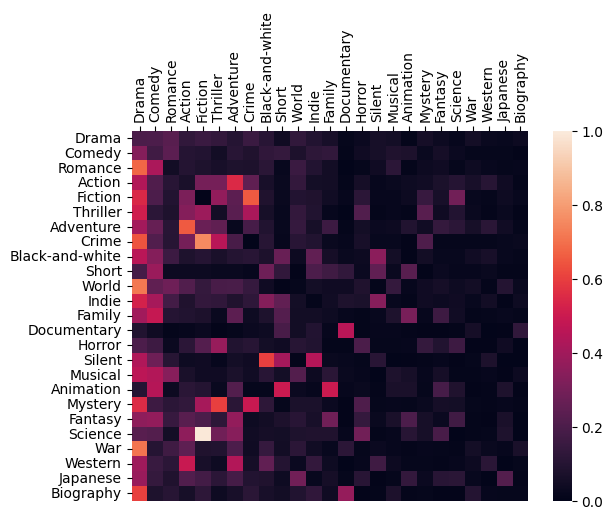

In [101]:
# Explode the genres and get dummies
genre_dummies = pd.get_dummies(movies["genres"].explode())
genre_dummies.index.name = "index"

# Group by index and sum
genre_dummies_grouped = genre_dummies.groupby("index").sum()

# Get the list of genres
genres_list = movies["genres"].explode().dropna().value_counts().index.to_list()

# Initialize co-occurrences matrix
co_occurrences_matrix = np.zeros((len(genres_list), len(genres_list)))

# Calculate co-occurrences
for x, genre_x in enumerate(genres_list):
    for y, genre_y in enumerate(genres_list):
        if genre_x == genre_y:
            co_occurrences_matrix[x, y] = (
                movies["genres"].apply(lambda x: x == {genre_x}).sum()
                / genre_dummies_grouped[genre_x].sum()
            )
        else:
            co_occurrences_matrix[x, y] = (
                (genre_dummies_grouped[genre_x] + genre_dummies_grouped[genre_y]) == 2
            ).sum() / genre_dummies_grouped[genre_x].sum()

# Plot heatmap
heatmap_ax = sns.heatmap(
    co_occurrences_matrix,
    xticklabels=genres_list,
    yticklabels=genres_list,
    vmax=1,
    vmin=0,
)

# Move x-axis to top and rotate labels
heatmap_ax.xaxis.tick_top()
plt.xticks(rotation=90);

# CHANTIER EN COURS

In [102]:
actors_exploded= explode_on_movies(actors)

In [103]:
# Merge actors_genres with movies dataset, explode the genres column
merged_actors_genres = actors_exploded.merge(movies[["fbID", "genres"]], how="left", on="fbID")
exploded_actors_genres = merged_actors_genres[["fbActorID", "fbID", "genres"]].explode(column="genres")

# Create dummy variables for genres and group and sum 
genre_dummies = pd.get_dummies(exploded_actors_genres, columns=["genres"], prefix="", prefix_sep="")
grouped_genre_dummies = (1 * genre_dummies).groupby(["fbActorID", "fbID"]).sum()

# Calculate the sum of genres for each actor and movie
grouped_genre_dummies["genresCounts"] = grouped_genre_dummies[genres_list].sum(axis="columns")

# Normalize by dividing by the total count of genres
normalized_genre_dummies = grouped_genre_dummies.div(grouped_genre_dummies["genresCounts"], axis=0)

# Group by fbActorID and sum again
grouped_normalized_genre_dummies = normalized_genre_dummies.groupby("fbActorID").sum()

# Filter actors with at least 100 genresCounts
filtered_genre_dummies = grouped_normalized_genre_dummies.query("genresCounts >= 10")

# Normalize again after filtering
final_genre_dummies = filtered_genre_dummies.div(filtered_genre_dummies["genresCounts"], axis=0)

# Group by fbActorID and sum again
final_grouped_genre_dummies = final_genre_dummies.groupby("fbActorID").sum()


In [104]:
len(final_grouped_genre_dummies)

9318

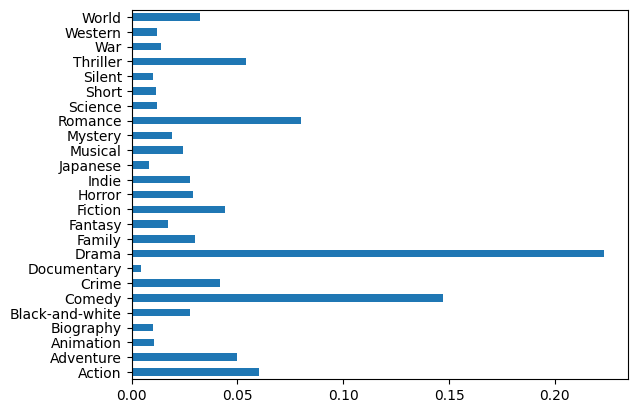

In [105]:
final_grouped_genre_dummies.drop(columns=["genresCounts"]).mean(axis="index").plot(kind="barh");

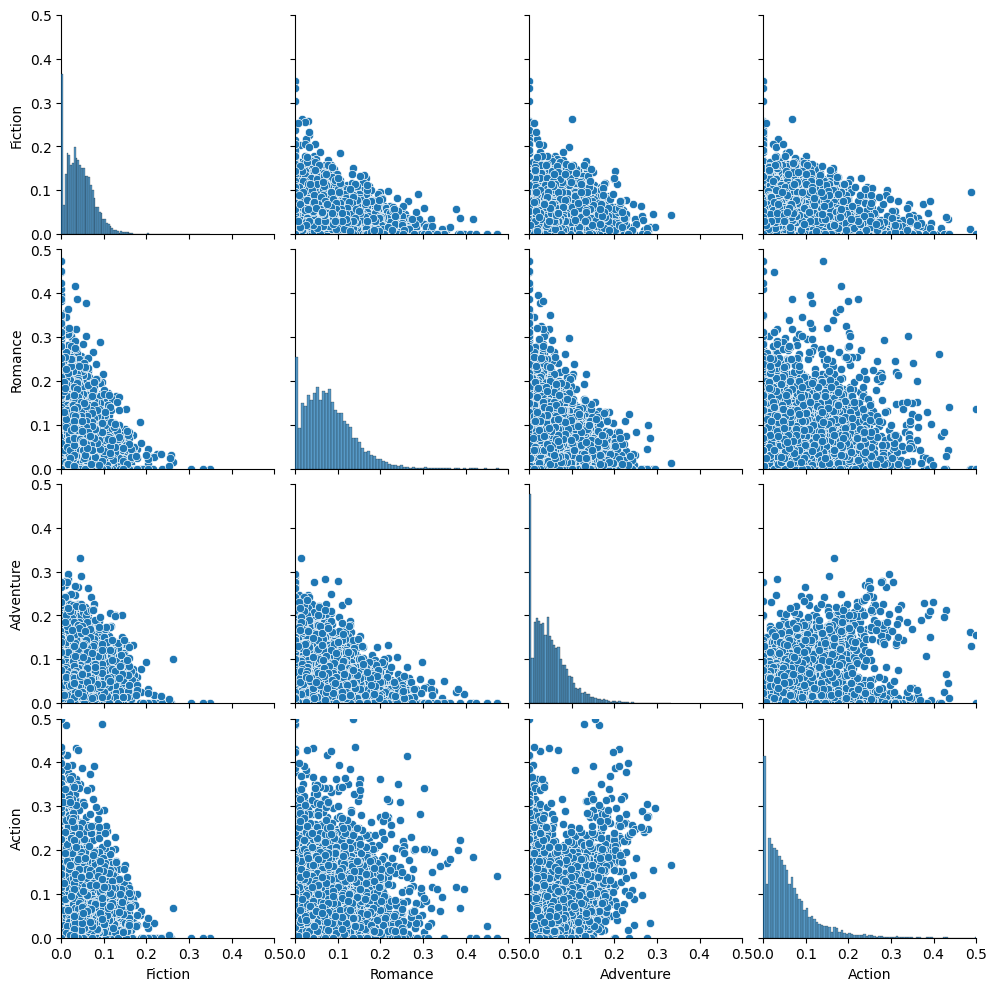

In [111]:
pairplot = sns.pairplot(
    final_grouped_genre_dummies[["Fiction", "Romance", "Adventure", "Action"]],
)
pairplot.set(ylim=[0,0.5], xlim=[0,0.5])

# FIN DU CHANTIER

## Saving Preprocessed Datasets

### Removing Unnecessary Columns

We are excluding columns containing information irrelevant to our analysis from all datasets to optimize memory usage and enhance readability.

In [107]:
# TODO enlever toutes les columns qu'on utilise pas dans TOUS les datasets

In [217]:
movies.to_csv(DATA_FOLDER + "movies.csv", index=False)
actors.to_csv(DATA_FOLDER + "actors.csv", index=False)

In [220]:
def parse_list_actors(string):
    """
    Parse a string representation of a list, safely evaluating it back into a list.

    Parameters:
    string (str): The string representation of a list.

    Returns:
    list: The list evaluated from the string, or np.nan if evaluation fails.
    """
    try:
        return string.split(",")
    except:
        return np.nan


In [221]:
actors_load = pd.read_csv(
    DATA_FOLDER + "actors.csv",
    converters={
        "fbID":parse_list_actors,
        "ageAtMovieRelease": parse_dict,
        "category": parse_dict,
        "winner": parse_dict,
    },
)
movies_load = pd.read_csv(
    DATA_FOLDER + "movies_imdb.csv",
    converters={
        "languages": parse_list,
        "countries": parse_list,
        "genres": parse_list
    },
)

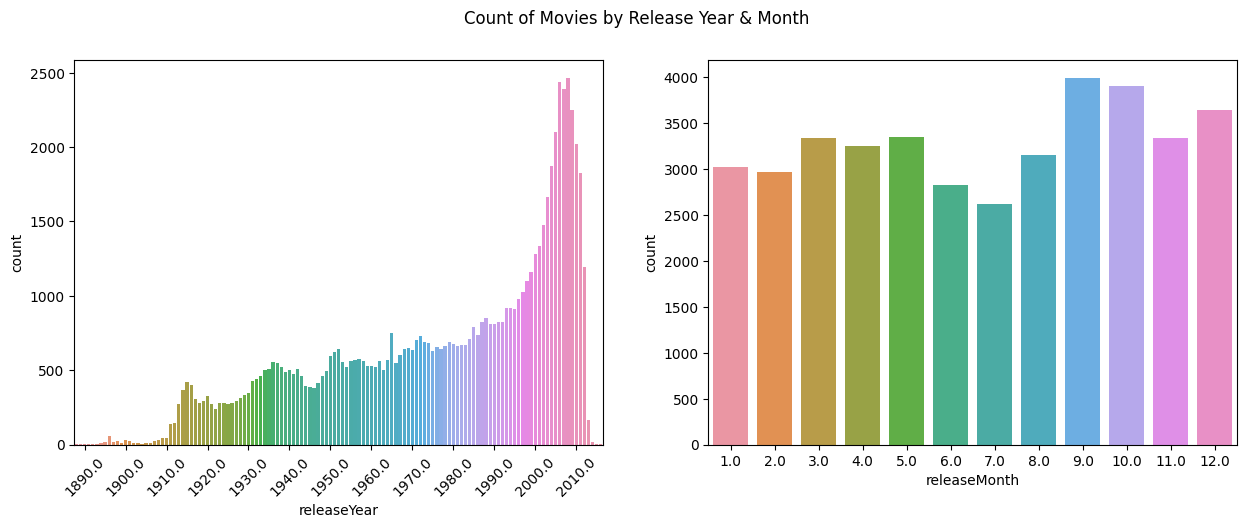

In [110]:
fig = plt.figure(figsize=(15,5))
fig.suptitle('Count of Movies by Release Year & Month')

fig.add_subplot(121)
sns.countplot(x='releaseYear', data=cmu_movies) 
plt.xticks(plt.xticks()[0][2::10], rotation=45)

fig.add_subplot(122)
sns.countplot(x="releaseMonth", data=cmu_movies)

plt.subplots_adjust(wspace=0.2)
plt.show()